# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pickle

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
import os

# Models to Tests

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
raw_df = pd.read_csv("data\CleanData.csv", index_col=0)

# Function to test models

In [7]:
def ml(df, model, grid, grid_params = 0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

    
    if grid:
        model = GridSearchCV(model, grid_params)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    print("R2 Score ", r2_score(y_test, preds))
    print('MAE:', metrics.mean_absolute_error(y_test, preds))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
    print('MAE(%):', metrics.mean_absolute_error(y_test, preds)/np.mean(y_test)*100, "%")
    plt.scatter(y_test, preds, label="Predykcje modelu")
    plt.plot(y_test, y_test, 'r', label='Właściwa cena domu')
    plt.title("Predykcje vs. właściwe ceny domów")
    plt.xlabel("Właściwa cena domu [USD]")
    plt.ylabel("Przewidziana cena domu [USD]")
    plt.legend()
    plt.show()
    if grid:
        print(model.best_params_)

# Correlation

<AxesSubplot:>

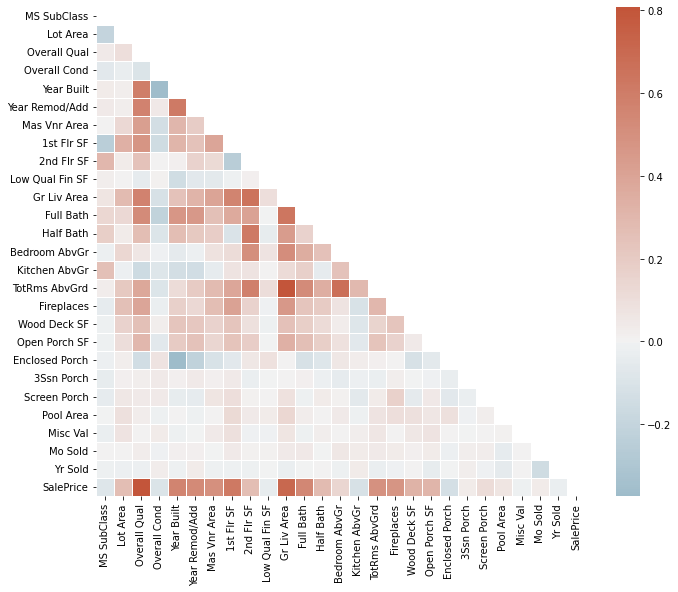

In [8]:
corr = raw_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5)

In [9]:
corr["SalePrice"][corr["SalePrice"] > 0]

Lot Area          0.266549
Overall Qual      0.799262
Year Built        0.558426
Year Remod/Add    0.532974
Mas Vnr Area      0.502196
1st Flr SF        0.621676
2nd Flr SF        0.269373
Gr Liv Area       0.706780
Full Bath         0.545604
Half Bath         0.285056
Bedroom AbvGr     0.143913
TotRms AbvGrd     0.495474
Fireplaces        0.474558
Wood Deck SF      0.327143
Open Porch SF     0.312951
3Ssn Porch        0.032225
Screen Porch      0.112151
Pool Area         0.068403
Mo Sold           0.035259
SalePrice         1.000000
Name: SalePrice, dtype: float64

In [10]:
corr["SalePrice"]

MS SubClass       -0.085092
Lot Area           0.266549
Overall Qual       0.799262
Overall Cond      -0.101697
Year Built         0.558426
Year Remod/Add     0.532974
Mas Vnr Area       0.502196
1st Flr SF         0.621676
2nd Flr SF         0.269373
Low Qual Fin SF   -0.037660
Gr Liv Area        0.706780
Full Bath          0.545604
Half Bath          0.285056
Bedroom AbvGr      0.143913
Kitchen AbvGr     -0.119814
TotRms AbvGrd      0.495474
Fireplaces         0.474558
Wood Deck SF       0.327143
Open Porch SF      0.312951
Enclosed Porch    -0.128787
3Ssn Porch         0.032225
Screen Porch       0.112151
Pool Area          0.068403
Misc Val          -0.015691
Mo Sold            0.035259
Yr Sold           -0.030569
SalePrice          1.000000
Name: SalePrice, dtype: float64

In [11]:
raw_df['TotRms AbvGrd'].max()

15

In [12]:
corr["SalePrice"][corr["SalePrice"] < -0.05]

MS SubClass      -0.085092
Overall Cond     -0.101697
Kitchen AbvGr    -0.119814
Enclosed Porch   -0.128787
Name: SalePrice, dtype: float64

### Thoughts

Observations such as the high correlation between price and overall quality, area above ground level and area on the second floor are not surprising.
However, the discovery that the overall condition of a house is gently but nevertheless inversely correlated with price is quite intriguing and warrants further analysis.

# Dealing with outliers

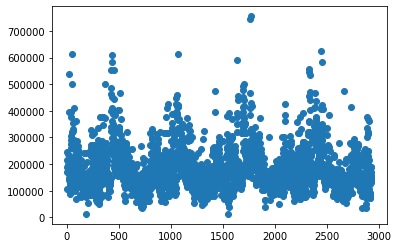

In [13]:
plt.scatter(x = raw_df.index, y = raw_df["SalePrice"])

In [14]:
min(raw_df["SalePrice"])

12789

In [15]:
len(raw_df)/100*2 #2% is ~ 58 records 

58.6

### We decided to remove 2% of the most expensive apartments and 2% of the cheapest ones

In [16]:
without_outliers = raw_df.sort_values(by="SalePrice")

In [17]:
without_outliers

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Neighborhood full name
Order,,,,,,,,,,,,,,,,,,,,,
182,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0,0,0,0,6,2010,WD,Abnorml,12789,Old Town
1554,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,...,0,0,0,0,2,2008,WD,Abnorml,13100,Iowa DOT and Rail Road
727,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,11,2009,WD,Abnorml,34900,Iowa DOT and Rail Road
2844,30,RL,8088,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,2,2006,ConLD,Normal,35000,Edwards
2881,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,10,2006,WD,Abnorml,35311,Iowa DOT and Rail Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,20,RL,12919,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,3,2010,New,Partial,611657,Northridge Heights
1064,20,RL,12720,Pave,Reg,HLS,AllPub,Inside,Mod,NridgHt,...,0,216,144,0,2,2008,WD,Normal,615000,Northridge Heights
2446,60,RL,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,7,2006,WD,Normal,625000,Northridge


In [18]:
len(raw_df) - 58

2872

In [19]:
without_outliers1 = without_outliers.head(2872)

In [20]:
without_outliers1

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Neighborhood full name
Order,,,,,,,,,,,,,,,,,,,,,
182,30,RM,9656,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,...,0,0,0,0,6,2010,WD,Abnorml,12789,Old Town
1554,20,A (agr),14584,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,...,0,0,0,0,2,2008,WD,Abnorml,13100,Iowa DOT and Rail Road
727,30,C (all),7879,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,11,2009,WD,Abnorml,34900,Iowa DOT and Rail Road
2844,30,RL,8088,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,2,2006,ConLD,Normal,35000,Edwards
2881,20,C (all),9000,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,10,2006,WD,Abnorml,35311,Iowa DOT and Rail Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,60,RL,46589,Pave,IR2,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,402000,Northridge
431,20,RL,12220,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,9,2009,New,Partial,402861,Northridge Heights
496,60,RL,15138,Pave,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,403000,Northridge


In [21]:
2872-58

2814

In [22]:
without_outliers2 = without_outliers1.tail(2814)

In [23]:
without_outliers2

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Neighborhood full name
Order,,,,,,,,,,,,,,,,,,,,,
2289,160,RM,2001,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,1,2007,WD,Normal,75000,Meadow Village
944,30,C (all),10200,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,5,2009,WD,Normal,75000,Iowa DOT and Rail Road
2678,50,RM,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,0,0,0,0,11,2006,ConLI,Abnorml,75000,Brookside
2291,160,RM,1890,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,0,0,0,0,4,2007,COD,Normal,75190,Meadow Village
2238,30,RM,3672,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,9,2007,WD,Normal,75200,Iowa DOT and Rail Road
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,60,RL,46589,Pave,IR2,Lvl,AllPub,CulDSac,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,402000,Northridge
431,20,RL,12220,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,...,0,0,0,0,9,2009,New,Partial,402861,Northridge Heights
496,60,RL,15138,Pave,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,...,0,0,0,0,7,2009,WD,Normal,403000,Northridge


### Save data without outliers

In [24]:
without_outliers2.to_csv('C:/Users/kacpe/Desktop/uczelnia/sem4/Projekt Systemy/data/data_without_outliers.csv', index=False)

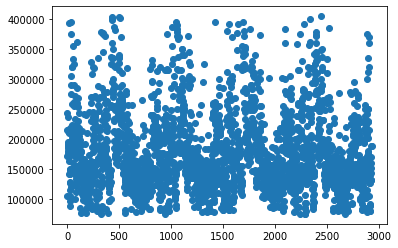

In [25]:
plt.scatter(x = without_outliers2.index, y = without_outliers2["SalePrice"])

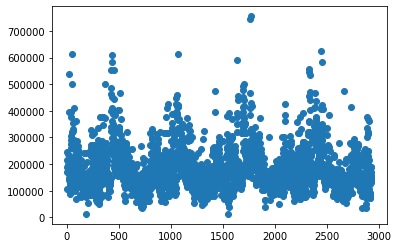

In [26]:
plt.scatter(x = raw_df.index, y = raw_df["SalePrice"])

### Dummies Variables with first column drop

In [27]:
dummies_df = pd.get_dummies(without_outliers2, drop_first = True)

In [28]:
dummies_df

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Neighborhood full name_Northridge Heights,Neighborhood full name_Northwest Ames,Neighborhood full name_Old Town,Neighborhood full name_Sawyer,Neighborhood full name_Sawyer West,Neighborhood full name_Somerset,Neighborhood full name_South & West of Iowa State University,Neighborhood full name_Stone Brook,Neighborhood full name_Timberland,Neighborhood full name_Veenker
Order,,,,,,,,,,,,,,,,,,,,,
2289,160,2001,4,5,1970,1970,80.0,546,546,0,...,0,0,0,0,0,0,0,0,0,0
944,30,10200,4,6,1925,1950,0.0,572,0,0,...,0,0,0,0,0,0,0,0,0,0
2678,50,6120,3,5,1930,1950,0.0,728,434,0,...,0,0,0,0,0,0,0,0,0,0
2291,160,1890,4,3,1976,1976,0.0,546,546,0,...,0,0,0,0,0,0,0,0,0,0
2238,30,3672,5,7,1922,1950,0.0,816,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,60,46589,8,7,1994,2005,528.0,1686,762,0,...,0,0,0,0,0,0,0,0,0,0
431,20,12220,10,5,2009,2009,305.0,2020,0,0,...,1,0,0,0,0,0,0,0,0,0
496,60,15138,8,5,1995,1996,506.0,1490,1304,0,...,0,0,0,0,0,0,0,0,0,0


# Spliting on X and y labels and train/test split with test size = 20%

In [29]:
y = dummies_df["SalePrice"]

In [30]:
X = dummies_df.drop(axis = 1, labels = "SalePrice")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [32]:
X_train

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Neighborhood full name_Northridge Heights,Neighborhood full name_Northwest Ames,Neighborhood full name_Old Town,Neighborhood full name_Sawyer,Neighborhood full name_Sawyer West,Neighborhood full name_Somerset,Neighborhood full name_South & West of Iowa State University,Neighborhood full name_Stone Brook,Neighborhood full name_Timberland,Neighborhood full name_Veenker
Order,,,,,,,,,,,,,,,,,,,,,
1858,120,3840,8,6,1978,1998,0.0,1295,0,0,...,0,0,0,0,0,0,0,0,0,0
1896,20,22002,6,7,1959,1991,136.0,1652,0,0,...,0,0,0,0,0,0,0,0,0,0
2150,60,8158,7,5,2002,2002,214.0,860,869,0,...,0,0,0,0,0,0,0,0,0,0
2112,60,9316,7,5,2005,2006,0.0,879,916,0,...,0,0,0,0,0,0,0,0,0,0
2013,45,6120,5,7,1939,1950,0.0,884,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,80,7700,5,7,1956,1956,0.0,1145,0,0,...,0,0,0,0,0,0,0,0,0,0
2440,60,10852,6,5,2000,2000,0.0,959,712,0,...,0,0,0,0,0,0,0,0,0,0
1913,80,9600,6,5,1961,1961,291.0,1254,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# X_test.to_csv('C:/Users/kacpe/Desktop/uczelnia/sem4/Projekt Systemy/data/X_test.csv')

In [34]:
# y_test.to_csv('C:/Users/kacpe/Desktop/uczelnia/sem4/Projekt Systemy/data/y_test.csv')

# Cross Validation Test 
### Best Models Selections

In [34]:
models = [SVR(),Ridge(), LinearRegression(), KNeighborsRegressor(),
         DecisionTreeRegressor(),RandomForestRegressor()]

In [ ]:
for model in models:
    cv_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_absolute_error")
    print(model,"",abs(cv_score.mean()))

### ad.1 The discrepancy in the result of two linear models that are linear regression and ridge may suggest that a sizable portion of features are without utility in estimating the price of a house. We will use mrmr selection: https://github.com/smazzanti/mrmr to reduce number of useless features

### ad.2 Given that the results of all models excluding SVR and linear regression are similar to each other. We decided to further develop the other four in the project, i.e.
### -Ridge
### -KNeighborsRegressor
### -DecisionTreeRegressor
### -RandomForestRegressor

# Ridge Regression (least squares regression with an L2 penalty term)

In [38]:
from sklearn.linear_model import Ridge 

In [39]:
grid_params = {
    'alpha': [0.15,0.5,1,1.5,2,5,10,20],
    'tol': [0.00001,0.00002,0.0001,.0005,0.01],
    'random_state' : [101]
}

In [40]:
ridge = Ridge()

R2 Score  0.8887900826903842
MAE: 14901.045507788966
RMSE: 21780.933715421615
MAE(%): 8.47612722236853 %


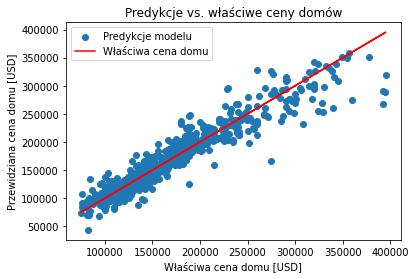

{'alpha': 10, 'random_state': 101, 'tol': 1e-05}


In [41]:
ml(dummies_df, ridge, True, grid_params)

### Thoughts: Ridge Regression make really nice job R2Score = 0,89
### With params : {'alpha': 10, 'random_state': 101, 'tol': 1e-05}

In [42]:
ridge_final = Ridge(alpha = 10, random_state  = 101, tol =  1e-05)

In [43]:
ridge_final.fit(X_train, y_train)

Ridge(alpha=10, random_state=101, tol=1e-05)

In [44]:
preds = ridge_final.predict(X_test)

In [45]:
r2_score(y_test, preds)

0.8887900826903842

In [37]:
filename = "C:/Users/kacpe/Desktop/uczelnia/sem4/Projekt Systemy/Models/ridge_final.sav"

### Model Save

In [48]:
pickle.dump(ridge_final, open(filename, 'wb'))

### Model Load

In [42]:
with open(filename, 'rb') as file:
    ridge_final = pickle.load(file)

# Analyse Based on Ridge Model

In [43]:
ridge_final.coef_

array([-1.32011849e+02,  6.15380288e-01,  9.01670289e+03, ...,
        1.22045903e+04, -8.24358770e+02,  2.14865266e+03])

In [44]:
np.reshape(X_test.columns.tolist(), (4316, 1)).T

array([['MS SubClass', 'Lot Area', 'Overall Qual', ...,
        'Neighborhood full name_Stone Brook',
        'Neighborhood full name_Timberland',
        'Neighborhood full name_Veenker']], dtype='<U60')

In [45]:
np.reshape(ridge_final.coef_, (4316, 1)).T

array([[-1.32011849e+02,  6.15380288e-01,  9.01670289e+03, ...,
         1.22045903e+04, -8.24358770e+02,  2.14865266e+03]])

### Coefficient DataFrame based on Ridge Model

In [46]:
coef_DataFrame = pd.DataFrame(data = np.reshape(ridge_final.coef_, (4316, 1)).T, columns=X_test.columns.tolist())

### Analysis of Roof Material parameters

In [47]:
RoofMaterials = ['Roof Matl_CompShg','Roof Matl_Membran','Roof Matl_Metal', "Roof Matl_Roll", 'Roof Matl_Roll',"Roof Matl_Tar&Grv",
                "Roof Matl_WdShake","Roof Matl_WdShngl"]

In [48]:
coef_DataFrame[RoofMaterials]

,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl
0,4620.523609,0.0,62.642731,1171.512254,1171.512254,1665.33068,1412.961592,9719.99152


* Roof Matl_CompShg (pl. płyty dachowe): 33-167 USD/m²
* Roof Matl_Membran (pl. membrany dachowe): 2,5-15 USD/m²
* Roof Matl_Metal (pl. blachodachówki): 33-167 USD/m²
* Roof Matl_Roll (pl. papy dachowe): 1-4 USD/m²
* Roof Matl_Tar&Grv (pl. papa z żwirkiem): 1,5-4 USD/m²
* Roof Matl_WdShake (pl. drewniane gonty): 100-500 USD/m²
* Roof Matl_WdShngl (pl. drewniane łupki): 50-100 USD/m²

Considering the cost of the above materials, as well as their value in the real estate market in Ames, the most profitable investment will be to choose Gravel & Tar.

### Analysis of  Vnr Type

In [49]:
VnrType = ["Mas Vnr Type_BrkFace","Mas Vnr Type_CBlock","Mas Vnr Type_None","Mas Vnr Type_Stone"]

In [50]:
coef_DataFrame[VnrType]

,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone
0,3191.331198,-2948.971007,3033.460275,1797.324963


Masonry veneer type has proven to be the best, but a complete lack of veneer is almost as desirable on the market. Therefore, it will be most optimal to give up veneer. 

### Analysis of Foundation

In [51]:
Foundation = ["Foundation_CBlock","Foundation_PConc","Foundation_Slab","Foundation_Stone","Foundation_Wood"]

In [52]:
coef_DataFrame[Foundation]

,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,2196.229958,4493.970529,-3703.231228,5629.956602,-634.420012


### Based on this prices
* Foundation_CBlock: $45-70/m²

* Foundation_PConc: $65-100/m²

* Foundation_Slab: $40-65/m²

* Foundation_Stone: $85-125/m²

* Foundation_Wood: $30-45/m²

Based on the above prices, stone foundations will work best for smaller homes, while it will probably be more cost-effective to use CBlock material when building larger properties.

### Analysis of Heating

In [53]:
heating = ["Heating_GasW","Heating_Grav","Heating_OthW","Heating_Wall" ]

In [54]:
coef_DataFrame[heating]

,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall
0,3152.390153,245.30188,-3596.673084,3574.589993


### Analysis of Heating

### Based on this prices
* Heating_GasW: 2500 - 7500 USD

* Heating_Grav: 3000 - 6000 USD

* Heating_OthW: 6000 - 12000 USD

* Heating_Wall: 1500 - 5 000 USD

Based on the above prices, the most cost-effective heating in terms of installation will be Heating Wall. Its installation is relatively cheap, while it raises the price of the house quite significantly.

### Analysis of Fireplaces

In [68]:
coef_DataFrame[["Fireplaces"]]

,Fireplaces
0,5482.71052


As a rough estimate, the cost of installing a fireplace in the US can range from 1000 to 5000 USD. So it definitely makes sense to install such a fireplace in a newly built house, as on average such a house gains more than $5,000 in value.

# KNN regression

In [47]:
KNeighborsRegressor()

KNeighborsRegressor()

In [48]:
grid_params = {
    'n_neighbors': [7,9,11,15,19],
    'weights': ['uniform', 'distance'],
    'algorithm' : ['auto'],
    'metric': ['cityblock', 'l1', 'l2']

}

R2 Score  0.6916407561055088
MAE: 25302.37817303733
RMSE: 36268.80282859065
MAE(%): 14.392693204717807 %


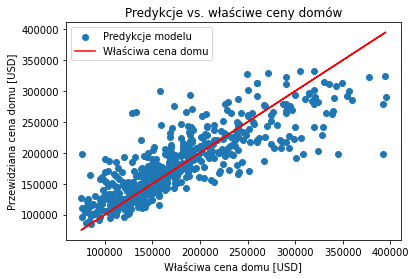

{'algorithm': 'auto', 'metric': 'cityblock', 'n_neighbors': 9, 'weights': 'distance'}


In [49]:
ml(dummies_df, KNeighborsRegressor(), True, grid_params)

### Thoughts: KNN Regresor is much weaker then ridge so we decided to not loading it.


# DecisionTreeRegressor

In [50]:
DecisionTreeRegressor()

DecisionTreeRegressor()

In [51]:
grid_params = {
    'criterion' : ["absolute_error"], 
    'random_state': [101],
    'min_impurity_decrease':[0.0001,0.0002,0.0005,0.001],
    'ccp_alpha': [0.1,0.2,0.3,0.4,0.5,0.6]


}

R2 Score  0.758458071674649
MAE: 21642.96269982238
RMSE: 32099.701881054527
MAE(%): 12.311116372121695 %


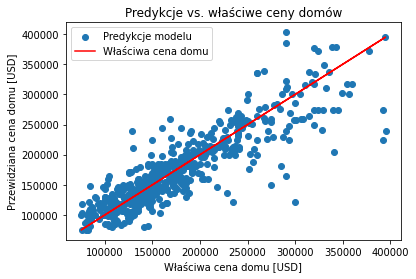

{'ccp_alpha': 0.3, 'criterion': 'absolute_error', 'min_impurity_decrease': 0.0001, 'random_state': 101}


In [52]:
ml(dummies_df, DecisionTreeRegressor(), True, grid_params)

# RandomForestRegressor

In [28]:
forest = RandomForestRegressor()

for n_estimators =  100
R2 Score  0.8820770557936126
MAE: 15304.721699230313
RMSE: 22428.68912159458
RMAE: 8.705749415892438 %
for n_estimators =  200
R2 Score  0.8828456271525128
MAE: 15273.375947306098
RMSE: 22355.47933338745
RMAE: 8.6879190843864 %
for n_estimators =  300
R2 Score  0.8837641334796313
MAE: 15339.74452634695
RMSE: 22267.67187935954
RMAE: 8.72567136956827 %
for n_estimators =  400
R2 Score  0.8847326067517256
MAE: 15109.459792776792
RMSE: 22174.711096818603
RMAE: 8.594679037648364 %
for n_estimators =  500
R2 Score  0.8842747094272112
MAE: 15200.65534517466
RMSE: 22218.711731757532
RMAE: 8.646553592613952 %
for n_estimators =  600
R2 Score  0.8842911211063934
MAE: 15188.972930728241
RMSE: 22217.13619327302
RMAE: 8.639908311847542 %
for n_estimators =  700
R2 Score  0.8840946494755262
MAE: 15191.92080605599
RMSE: 22235.99034541487
RMAE: 8.64158514494631 %
for n_estimators =  800
R2 Score  0.8842759854379912
MAE: 15167.907946269983
RMSE: 22218.589237384433
RMAE: 8.627925

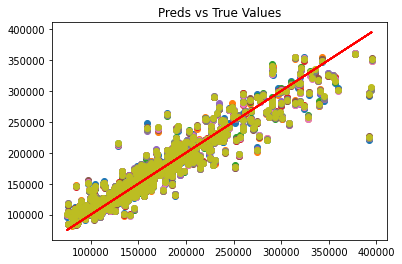

In [41]:
for i in range(1,10):
    print("for n_estimators = ", i*100)
    ml(dummies_df, RandomForestRegressor(n_estimators = i*100), False, grid_params)

#### Since the value of n_estimators = 400 you will not see a significant difference in the results, so we will use this number of estimators.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

#### Criterion = mean_absolute_error too much time consuming

In [28]:
# verbose=10 to check!!!

In [35]:
grid_params = {
    'bootstrap': [True],
    'ccp_alpha':[0.01,0.02,0.05],
    'random_state':[101],
    'n_estimators': [400]
    
}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   46.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   48.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   47.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

R2 Score  0.8838044168103165
MAE: 15290.07836900533
RMSE: 22263.81294257476
RMAE: 8.697419884257812 %
{'bootstrap': True, 'ccp_alpha': 0.02, 'n_estimators': 400, 'random_state': 101}


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


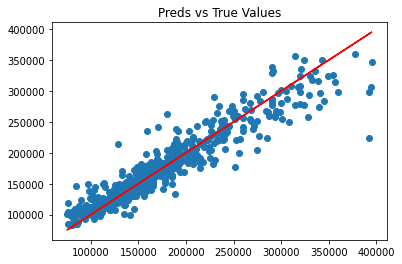

In [30]:
    ml(dummies_df, RandomForestRegressor(verbose=1), True, grid_params)

R2 Score  0.8837523461631538
MAE: 15266.411347411355
RMSE: 22268.80091745046
RMAE(%): 8.683957427150341 %


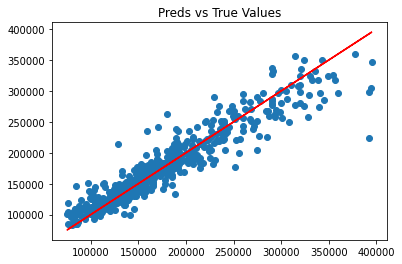

In [36]:
ml(dummies_df, RandomForestRegressor(bootstrap = True, ccp_alpha = 0.025, n_estimators = 450, random_state = 101),
   False, grid_params)

## As the decision tree-based models did quite well, we decided to test the rest of the tree-based models, namely adaboost and gradientboost.

# AdaBoost

In [42]:
from sklearn.ensemble import AdaBoostRegressor

#### As the base estimator for the Adaptive boost model, we used a decision tree with the parameters selected earlier in the Decission Tree Regressor section.

In [43]:
tree = DecisionTreeRegressor(ccp_alpha = 0.3, criterion = 'absolute_error', min_impurity_decrease = 0.0001, random_state =  101)

### N_estimators

#### A loop was created below to see how the model performs with the number of estimators used being 50, 100, 150, 200 and 250.

R2 Score  0.8888105827828874
MAE: 14535.404973357015
RMSE: 21778.92610789077
MAE(%): 8.268140763574076 %


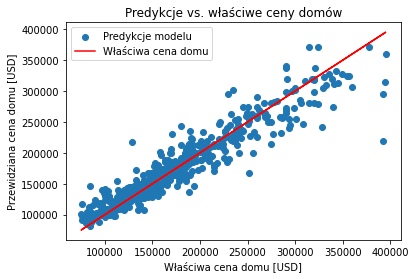

R2 Score  0.8910372138165493
MAE: 14555.480461811723
RMSE: 21559.755642629472
MAE(%): 8.279560257199833 %


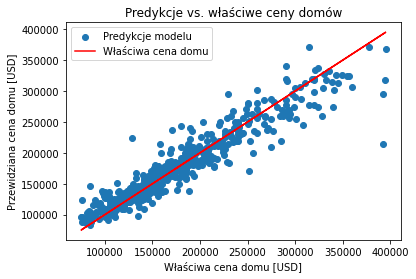

R2 Score  0.8901715154435208
MAE: 14638.414742451154
RMSE: 21645.231249413486
MAE(%): 8.32673557207475 %


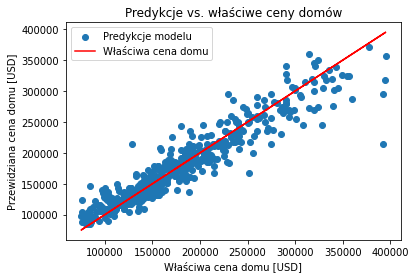

R2 Score  0.8923056116841606
MAE: 14403.26376554174
RMSE: 21433.903514730453
MAE(%): 8.192975186220847 %


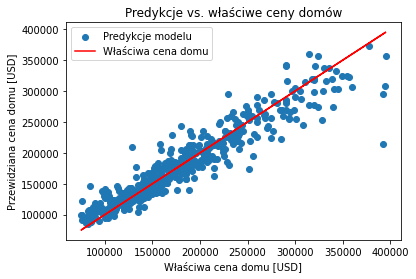

R2 Score  0.8926035852396397
MAE: 14390.210479573712
RMSE: 21404.230843591944
MAE(%): 8.185550115780178 %


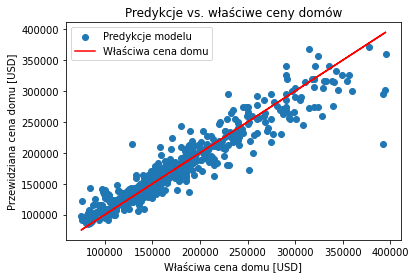

In [44]:
for i in range(1,6):
    ml(dummies_df, AdaBoostRegressor(base_estimator=tree, n_estimators=50*i) , False, 0)
    

#### In this case, the model using the number of estimators equal to 250 won slightly.

### Learning_rate


#### Learning_Rate was also selected using a loop for together were checked values from 0.2 to 2 with a step of 0.2, and the best performed learning_rate equal to 1.

R2 Score  0.8698896972513174
MAE: 16066.816163410302
RMSE: 23559.20212268738
MAE(%): 9.139249845810314 %


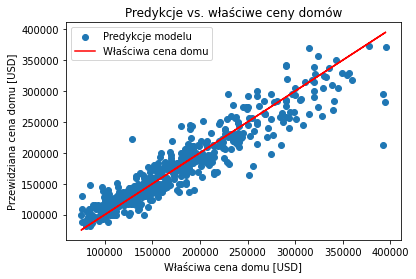

R2 Score  0.8814092359799992
MAE: 15355.204262877442
RMSE: 22492.108402126327
MAE(%): 8.734465295711791 %


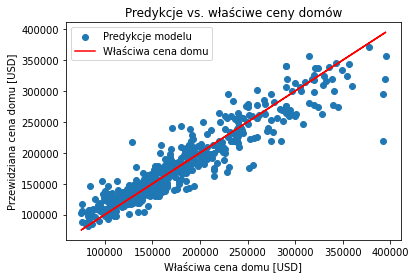

R2 Score  0.8775553467270695
MAE: 15451.538188277087
RMSE: 22854.653815914455
MAE(%): 8.789262699497366 %


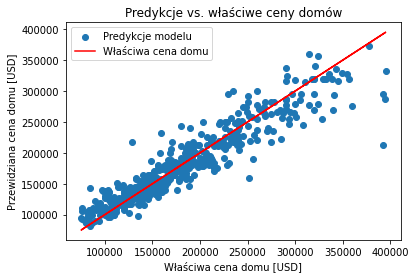

R2 Score  0.871483802510717
MAE: 15943.491119005328
RMSE: 23414.434220125393
MAE(%): 9.069099146281586 %


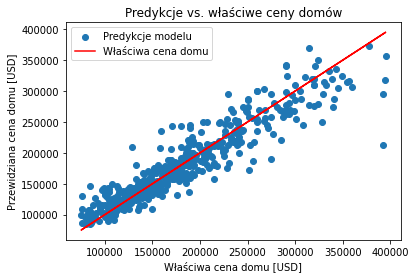

R2 Score  0.8824268531924324
MAE: 15078.988454706927
RMSE: 22395.399061382257
MAE(%): 8.577346096950949 %


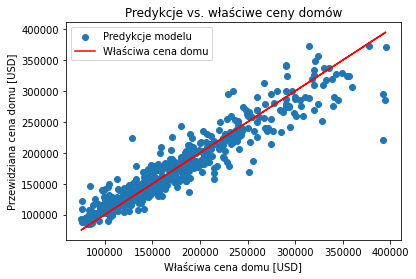

R2 Score  0.8843760196867005
MAE: 15189.511545293073
RMSE: 22208.984055531746
MAE(%): 8.640214690723639 %


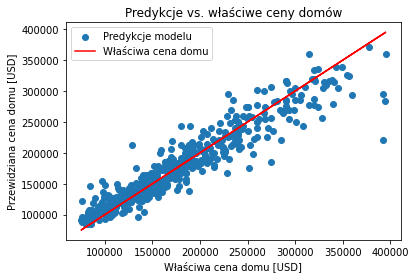

R2 Score  0.8877549453007336
MAE: 14927.028419182949
RMSE: 21882.066947324958
MAE(%): 8.49090702170998 %


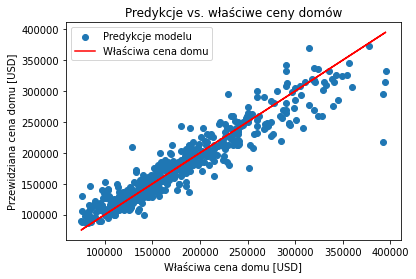

R2 Score  0.8757870650771225
MAE: 15363.970692717585
RMSE: 23019.08974878869
MAE(%): 8.739451883704705 %


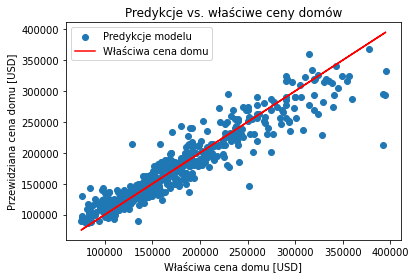

R2 Score  0.883161925392733
MAE: 15063.576376554174
RMSE: 22325.280811138327
MAE(%): 8.568579280212116 %


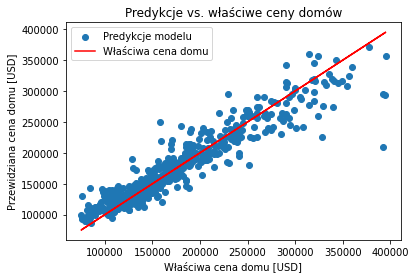

R2 Score  0.8819639409093891
MAE: 15871.690941385436
RMSE: 22439.44364645706
MAE(%): 9.028257217453389 %


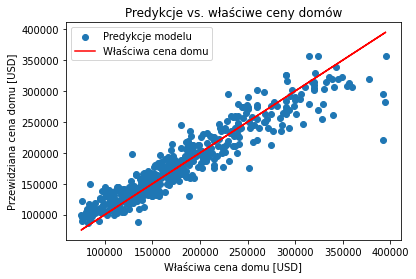

In [45]:
for i in range(1,11):
    ml(dummies_df, AdaBoostRegressor(base_estimator=tree,n_estimators=25,learning_rate=i*0.2 ) , False, 0)

### The best adaptive boost model.

R2 Score  0.8913262720643952
MAE: 14501.866785079928
RMSE: 21531.13961690107
MAE(%): 8.249063313572616 %


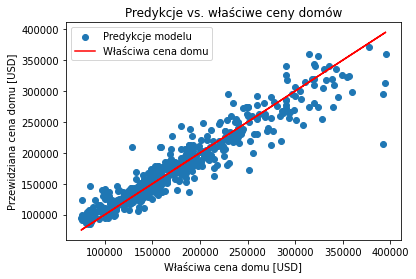

In [36]:
ml(dummies_df, AdaBoostRegressor(base_estimator=tree,n_estimators=250,learning_rate=1 ) , False, 0)

# Gradient Boost

In [35]:
gradient = GradientBoostingRegressor()

### For Gradient Boost, we used the GridSearchCV function to select the most optimal combination of parameters which turned out to be: n_estimators=250, min_impurity_decrease=0.0001, tol=0.00001, learning_rate=0.125, max_depth=5, ccp_alpha=0.01.

In [36]:
grid_params = {
    'n_estimators': [100,150,200,250],
    'learning_rate':[0.01,0.02,0,2,0.5,0.7,1],
    'min_impurity_decrease':[0.0001,0.001,0.01],
    'tol':[0.00001,0.0002,0.0001,0.001],
    'learning_rate':[0.1,0.125,0.2,0.5],
    'max_depth':[3,4,5,7],
    'ccp_alpha':[0.01,0.02,0.05,.1]
}

### The best Gradient Boost Model.

R2 Score  0.9040919302134068
MAE: 13881.15387389558
RMSE: 20227.038903211018
MAE(%): 7.8959846251668155 %


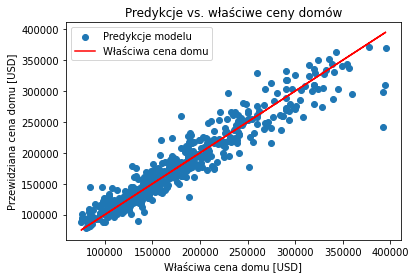

In [37]:
ml(dummies_df, GradientBoostingRegressor(n_estimators=250, min_impurity_decrease=0.0001,tol=0.00001,learning_rate=0.125, max_depth=5,
                                        ccp_alpha=0.01) , False, grid_params)

# Summary of Adaptive Boost and Gradient Boost Results.

### The results of both models turned out to be very good, especially the result of the last one, which achieved an MAE of less than 8%.

In [38]:
gradient = GradientBoostingRegressor(n_estimators=250, min_impurity_decrease=0.000001,tol=0.00001,learning_rate=0.125, max_depth=5,
                                        ccp_alpha=0.01).fit(X_train, y_train)

In [39]:
preds = gradient.predict(X_test)

In [40]:
r2_score(y_test,preds)

0.9054323004545957

In [41]:
filename = "C:/Users/kacpe/Desktop/uczelnia/sem4/Projekt Systemy/Models/gradient_final_model.sav"

## Save the best model

In [41]:
pickle.dump(gradient, open(filename, 'wb'))

## Load the best model

In [37]:
with open(filename, 'rb') as file:
    gradient = pickle.load(file)

# Sale Price Analyse besed on gradient model
### Model with Data leakage

In [55]:
X_raw = dummies_df.drop("SalePrice", axis = 1)

In [56]:
Y = dummies_df["SalePrice"]

In [57]:
gradient = GradientBoostingRegressor(n_estimators=250, min_impurity_decrease=0.000001,tol=0.00001,learning_rate=0.125, max_depth=5,
                                        ccp_alpha=0.01).fit(X_raw, Y)

In [58]:
preds = gradient.predict(X_raw)

In [59]:
r2_score(Y, preds)

0.9838928815090707

### Function to check how improving the condition of an apartment affects the cenee The function was created to check whether an apartment that we will want to renovate and sell is worth buying in a particular neighborhood.

In [61]:
raw_df["Neighborhood full name"].unique()

array(['North Ames', 'Gilbert', 'Stone Brook', 'Northwest Ames',
       'Somerset', 'Briardale', 'Northpark Villa', 'Northridge Heights',
       'Bloomington Heights', 'Northridge', 'Sawyer West', 'Sawyer', nan,
       'Brookside', 'Old Town', 'Iowa DOT and Rail Road', 'Clear Creek',
       'South & West of Iowa State University', 'Edwards',
       'College Creek', 'Crawford', 'Bluestem', 'Mitchell', 'Timberland',
       'Meadow Village', 'Veenker'], dtype=object)

In [62]:
def value_change_after_apartment_renovation(model,dummies_df,neigh,before_renovation,after_renovation, df):
    X_raw = dummies_df.drop("SalePrice", axis = 1)
    X_raw["Overall Cond"] = before_renovation
    preds = model.predict(X_raw)
    X_raw["Overall Cond"] = after_renovation
    preds2 = model.predict(X_raw)
    df.insert(1, 'Price_with_terrible_cond', preds)
    df.insert(1, 'Price_after_renovation', preds2)
    df_neigh = df[df["Neighborhood full name"] == neigh]
    df_neigh["Diff"] = df_neigh["Price_after_renovation"] - df_neigh["Price_with_terrible_cond"]
    df.drop(["Price_with_terrible_cond", "Price_after_renovation"], axis = 1, inplace=True)
    return round( np.mean(df_neigh["Diff"]))
    
    
    

In [65]:
df_with_preds = value_change_after_apartment_renovation(gradient,dummies_df,'Bluestem',1,10, without_outliers2)

C:\Users\kacpe\AppData\Local\Temp/ipykernel_14388/3191496509.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neigh["Diff"] = df_neigh["Price_after_renovation"] - df_neigh["Price_with_terrible_cond"]
C:\Users\kacpe\AppData\Local\Temp/ipykernel_14388/3191496509.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Price_with_terrible_cond", "Price_after_renovation"], axis = 1, inplace=True)
